# Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Base path definition
BASE_PATH = Path(__file__).parent if '__file__' in globals() else Path().resolve()

# Functions

In [2]:
def load_datasets(data_dir: str = "data") -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load the three core datasets: orders, marketing points, and prices.

    Parameters:
        data_dir (str): Name of the folder containing the CSV files. Defaults to "data".

    Returns:
        Tuple containing:
            - orders_df (pd.DataFrame): historical orders with columns ['product','client','date','quantity'].
            - points_df (pd.DataFrame): marketing points with columns ['product','client','date','points'].
            - price_df (pd.DataFrame): product prices with columns ['product','date','price'].
    """
    data_path = BASE_PATH / data_dir

    orders_df = pd.read_csv(data_path / "historical_orders.csv")
    points_df = pd.read_csv(data_path / "marketing_points.csv")
    price_df  = pd.read_csv(data_path / "price.csv")

    return orders_df, points_df, price_df

def plot_dual_axis(series_left: pd.Series, series_right: pd.Series,
                   left_label: str, right_label: str, title: str) -> None:
    """
    Plot two time series on a shared x-axis with separate y-axes.

    Parameters:
        series_left (pd.Series): First series (plotted on left y-axis).
        series_right (pd.Series): Second series (plotted on right y-axis).
        left_label (str): Label for the left y-axis.
        right_label (str): Label for the right y-axis.
        title (str): Chart title.

    Returns:
        None: Displays the plot inline.
    """
    fig, ax_left = plt.subplots(figsize=(14, 6))

    ax_left.plot(series_left.index, series_left, color='tab:blue', label=left_label)
    ax_left.set_ylabel(left_label, color='tab:blue')
    ax_left.tick_params(axis='y', labelcolor='tab:blue')

    ax_right = ax_left.twinx()
    ax_right.plot(series_right.index, series_right, color='tab:orange', linestyle='--', label=right_label)
    ax_right.set_ylabel(right_label, color='tab:orange')
    ax_right.tick_params(axis='y', labelcolor='tab:orange')

    plt.title(title)
    fig.tight_layout()
    plt.grid(True)
    plt.show()

def print_average_daily_points(points_df: pd.DataFrame) -> float:
    """
    Calculate the overall average daily marketing points.

    Parameters:
        points_df (pd.DataFrame): DataFrame with at least columns ['date','points'].

    Returns:
        float: The computed average daily points.
    """
    df = points_df.copy()
    df['date'] = pd.to_datetime(df['date'])

    daily_totals = df.groupby(df['date'].dt.date)['points'].sum()
    total_days   = daily_totals.size
    overall_sum  = daily_totals.sum()
    average_daily = overall_sum / total_days

    return average_daily

def prepare_daily_series(
    orders_df: pd.DataFrame,
    points_df: pd.DataFrame,
    date_col: str = 'date',
    quantity_col: str = 'quantity',
    points_col: str = 'points'
) -> tuple[pd.Series, pd.Series]:
    """
    Aggregate and align daily sales and marketing points series.

    Parameters:
        orders_df (pd.DataFrame): DataFrame with order data, must contain date_col and quantity_col.
        points_df (pd.DataFrame): DataFrame with marketing points data, must contain date_col and points_col.
        date_col (str): Name of the date column in both DataFrames.
        quantity_col (str): Name of the sales quantity column in orders_df.
        points_col (str): Name of the marketing points column in points_df.

    Returns:
        daily_quantity (pd.Series): Daily summed quantity, reindexed to full date range.
        daily_points (pd.Series): Daily summed points, reindexed to full date range.
    """
    # Ensure datetime
    orders = orders_df.copy()
    points = points_df.copy()
    orders[date_col] = pd.to_datetime(orders[date_col])
    points[date_col] = pd.to_datetime(points[date_col])

    # Aggregate
    daily_quantity = (
        orders.groupby(date_col)[quantity_col]
        .sum()
    )
    daily_points = (
        points.groupby(date_col)[points_col]
        .sum()
    )

    # Full date range
    start = min(daily_quantity.index.min(), daily_points.index.min())
    end   = max(daily_quantity.index.max(), daily_points.index.max())
    full_range = pd.date_range(start=start, end=end, freq='D')

    daily_quantity = daily_quantity.reindex(full_range, fill_value=0)
    daily_points   = daily_points.reindex(full_range, fill_value=0)

    return daily_quantity, daily_points

def analyze_seasonality(
    daily_quantity: pd.Series,
    daily_points: pd.Series,
    window: int = 180,
    period: int = 365
) -> None:
    """
    Perform seasonal analysis with two side-by-side plots.

    Parameters:
        daily_quantity (pd.Series): Daily sales series indexed by date.
        daily_points (pd.Series): Daily marketing points series indexed by date.
        window (int): Rolling window size for smoothing (in days).
        period (int): Seasonal decomposition period (in days).

    Returns:
        None: Displays two plots side by side:
          1. Rolling mean of sales vs points before deseasonalization.
          2. Rolling mean after deseasonalization vs points.
    """
    # Compute rolling means
    rolling_qty = daily_quantity.rolling(window).mean()
    rolling_pts = daily_points.rolling(window).mean()

    # Seasonal decomposition
    decomposition = seasonal_decompose(daily_quantity, model='additive', period=period)
    deseasoned = daily_quantity - decomposition.seasonal
    rolling_deseasoned = deseasoned.rolling(window).mean()

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

    # Plot before deseasonalization
    ax1.plot(rolling_qty.index, rolling_qty, label='Sales (rolling mean)', color='tab:blue')
    ax1.set_ylabel('Sales (rolling mean)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax1_2 = ax1.twinx()
    ax1_2.plot(rolling_pts.index, rolling_pts, label='Marketing Points (rolling mean)', color='tab:orange', linestyle='--')
    ax1_2.set_ylabel('Marketing Points (rolling mean)', color='tab:orange')
    ax1_2.tick_params(axis='y', labelcolor='tab:orange')

    ax1.set_title('Before Deseasonalization')
    ax1.grid(True)

    # Plot after deseasonalization
    ax2.plot(rolling_deseasoned.index, rolling_deseasoned, label='Deseasonalized Sales (rolling mean)', color='tab:green')
    ax2.set_ylabel('Deseasonalized Sales (rolling mean)', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    ax2_2 = ax2.twinx()
    ax2_2.plot(rolling_pts.index, rolling_pts, label='Marketing Points (rolling mean)', color='tab:orange', linestyle='--')
    ax2_2.set_ylabel('Marketing Points (rolling mean)', color='tab:orange')
    ax2_2.tick_params(axis='y', labelcolor='tab:orange')

    ax2.set_title('After Deseasonalization')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_raw_price_by_product(price_df: pd.DataFrame):
    """
    Plot the raw price variation over time for each product.

    Parameters
    ----------
    price_df : pd.DataFrame
        DataFrame with at least 'date', 'product', and 'price' columns.
    """
    # Ensure datetime format
    price_df['date'] = pd.to_datetime(price_df['date'])

    # Pivot table: dates as index, products as columns
    pivot_df = price_df.pivot(index='date', columns='product', values='price')

    # Plot
    plt.figure(figsize=(6, 3))
    for product in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[product], label=f'Product {product}')
    
    plt.title('Raw Price Variation by Product Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compute_marketing_sales_correlation(
    historical_orders: pd.DataFrame,
    marketing_points: pd.DataFrame,
    window: int,
    seasonality_period: int = 365
) -> pd.DataFrame:
    """
    Compute the correlation between deseasonalized sales and marketing points 
    for each product using rolling average time series.

    Parameters
    ----------
    historical_orders : pd.DataFrame
        DataFrame with columns ['date', 'client', 'product', 'quantity'].
    marketing_points : pd.DataFrame
        DataFrame with columns ['date', 'client', 'product', 'points'].
    window : int
        Rolling window size for smoothing (in days).
    seasonality_period : int, optional
        Period for seasonal decomposition (default is 365 for yearly seasonality).

    Returns
    -------
    pd.DataFrame
        DataFrame with 'product' and 'correlation' columns.
    """
    # Ensure datetime format
    historical_orders['date'] = pd.to_datetime(historical_orders['date'])
    marketing_points['date'] = pd.to_datetime(marketing_points['date'])

    # Aggregate daily sales and points by product
    sales_daily = historical_orders.groupby(['date', 'product'])['quantity'].sum().unstack(fill_value=0)
    points_daily = marketing_points.groupby(['date', 'product'])['points'].sum().unstack(fill_value=0)

    # Reindex both to the full date range
    full_range = pd.date_range(
        start=min(sales_daily.index.min(), points_daily.index.min()),
        end=max(sales_daily.index.max(), points_daily.index.max()),
        freq='D'
    )

    sales_daily = sales_daily.reindex(full_range, fill_value=0)
    points_daily = points_daily.reindex(full_range, fill_value=0)

    # Deseasonalize sales for each product
    deseasonalized_sales = pd.DataFrame(index=sales_daily.index)
    for product in sales_daily.columns:
        series = sales_daily[product]
        if series.sum() == 0:
            deseasonalized_sales[product] = 0
        else:
            try:
                decomposition = seasonal_decompose(series, model='additive', period=seasonality_period, extrapolate_trend='freq')
                deseasonalized_sales[product] = series - decomposition.seasonal
            except:
                deseasonalized_sales[product] = series  # fallback if decomposition fails

    # Rolling averages
    sales_smoothed = deseasonalized_sales.rolling(window=window, min_periods=1).mean()
    points_smoothed = points_daily.rolling(window=window, min_periods=1).mean()

    # Compute correlation for each product
    correlations = []
    for product in sales_smoothed.columns:
        if product in points_smoothed.columns:
            corr = sales_smoothed[product].corr(points_smoothed[product])
            correlations.append({'product': product, 'correlation': corr})

    return pd.DataFrame(correlations).sort_values(by='correlation', ascending=False)

def plot_window_correlation_by_product(
    historical_orders: pd.DataFrame,
    marketing_points: pd.DataFrame,
    seasonality_period: int = 365,
    min_window: int = 1,
    max_window: int = 180,
    figsize=(5, 3)
):
    """
    Plots side-by-side the correlation between marketing points and deseasonalized sales
    over a range of moving average windows for each product.

    Parameters:
        historical_orders (pd.DataFrame): DataFrame with 'date', 'product', and 'quantity' columns.
        marketing_points (pd.DataFrame): DataFrame with 'date', 'product', and 'points' columns.
        seasonality_period (int): Period to use for seasonality decomposition.
        min_window (int): Minimum moving average window size.
        max_window (int): Maximum moving average window size.
        figsize (tuple): Individual subplot size (width, height) per product.
    """
    # Dictionary to store all correlations per product
    all_correlations = {}

    # Loop over window sizes
    for window in range(min_window, max_window + 1):
        correlations = compute_marketing_sales_correlation(
            historical_orders=historical_orders,
            marketing_points=marketing_points,
            window=window,
            seasonality_period=seasonality_period
        )
        
        for _, row in correlations.iterrows():
            product = row['product']
            corr = row['correlation']
            
            if product not in all_correlations:
                all_correlations[product] = {'window': [], 'correlation': []}
            
            all_correlations[product]['window'].append(window)
            all_correlations[product]['correlation'].append(corr)

    # Number of products
    products = list(all_correlations.keys())
    n_products = len(products)

    # Create subplots in a single row
    fig, axes = plt.subplots(1, n_products, figsize=(figsize[0]*n_products, figsize[1]), sharey=True)

    if n_products == 1:
        axes = [axes]  # Ensure axes is iterable

    # Plot each product's correlation trend
    for ax, product in zip(axes, products):
        data = all_correlations[product]
        ax.plot(data['window'], data['correlation'], marker='o')
        ax.set_title(f'Product {product}')
        ax.set_xlabel('Window (days)')
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.grid(True)

    axes[0].set_ylabel('Correlation')
    plt.tight_layout()
    plt.show()

# Exploratory Data Analysis

Iniciamos comparando as séries temporais de vendas (`historical_orders`) com os pontos de marketing (`marketing_points`). Identificamos que a correlação entre essas variáveis se torna mais evidente quando aplicamos médias móveis às séries, o que suaviza flutuações de curto prazo e destaca tendências mais amplas.

No entanto, as séries de vendas apresentam uma sazonalidade anual bastante pronunciada. Para representar de forma mais precisa a relação com os pontos de marketing, esse efeito sazonal foi removido, possibilitando uma análise de correlação mais robusta.

Após a dessazonalização, observamos que os produtos **0** e **1** apresentam correlações significativas com os pontos de marketing, variando entre **0.4 e 0.5**, com aumento consistente à medida que a janela da média móvel cresce. Já o produto **2** mostra uma correlação menor, com um pico por volta de **34 dias de janela**, seguido de uma redução conforme janelas maiores são utilizadas.

Ao analisarmos a evolução dos preços ao longo do tempo, verificamos que **não ocorreram variações substanciais**. Os preços permaneceram relativamente estáveis nos últimos anos, o que reduz a chance de confundirmos efeitos de preço com o impacto dos pontos de marketing.

In [ ]:
historical_orders, marketing_points, price = load_datasets()

In [ ]:
daily_quantity, daily_points = prepare_daily_series(historical_orders, marketing_points, date_col='date',
                                                    quantity_col='quantity', points_col='points')

analyze_seasonality(daily_quantity, daily_points, window=180, period=365)

In [ ]:
plot_raw_price_by_product(price)

In [ ]:
plot_window_correlation_by_product(historical_orders=historical_orders, marketing_points=marketing_points,
                                   seasonality_period=365, min_window=1, max_window=90)

In [ ]:
average_daily = print_average_daily_points(marketing_points)
print(f"Average daily marketing points over the period: {average_daily:.2f}")

# Conclusão da análise exploratória e descrição da metodologia adotada

### Modelamento do Comportamento dos Clientes e Alocação Ótima de Pontos

Identificamos que o impacto dos pontos de marketing sobre as vendas varia de acordo com o produto, sendo necessário analisar cada produto separadamente. Assim, optamos por **modelar o comportamento dos clientes com relação aos pontos de marketing recebidos por produto**.

A modelagem individual por cliente, no entanto, é inviável devido à **baixa frequência de registros por cliente**, o que impede o aprendizado adequado de seus padrões de resposta. Para contornar essa limitação, optamos por **agrupar os clientes em quatro grupos**, com base na **relação entre os pontos de marketing recebidos e a quantidade de compras realizadas**. Essa abordagem nos permite **diferenciar clientes mais influenciados pelo marketing daqueles menos sensíveis**, viabilizando um modelamento mais robusto.

Para mapear o comportamento de cada grupo de clientes, utilizamos uma **rede neural do tipo MLP (Multi-Layer Perceptron)**. O modelo é alimentado com **features derivadas das médias móveis das séries de marketing e vendas**, tais como:

- Pontos de marketing alocados no dia atual;
- Médias móveis de pontos de marketing até o dia atual;
- Quantidade de vendas do dia anterior;
- Médias móveis de vendas até o dia anterior.

O objetivo do modelo é **prever a quantidade de vendas do dia atual** e também as **médias móveis das vendas dos próximos dias**, permitindo identificar o impacto imediato e futuro dos pontos de marketing investidos hoje.

Com o comportamento aprendido para cada grupo de clientes, seguimos para a etapa de **otimização da receita**. Nessa fase, testamos diversas combinações possíveis de pontos de marketing entre produtos e grupos, utilizando o modelo treinado para prever as vendas e calcular a receita correspondente. A **combinação que retorna a maior receita** é selecionada.

Após essa alocação ideal entre produtos e grupos, os pontos de marketing são **distribuídos de forma simples entre os clientes dentro de cada grupo**, já que **não há, por ora, padrões mais sofisticados identificáveis para otimização no nível individual**.

A proposta final do modelo é que ele **faça o planejamento da alocação de pontos para o dia atual**, utilizando as informações dos últimos 180 dias. No entanto, o mesmo modelo pode ser **usado de forma recursiva** para simular a evolução futura e **planejar vários dias à frente**, se necessário.

# Treinando as redes neurais que vão modelar o comportamento dos grupos de clientes por produtos

In [ ]:
def deseasonalize_spent(
    df: pd.DataFrame,
    product_col: str = "product",
    date_col: str = "date",
    value_col: str = "spend",
    period: int = 365,
    model: str = "additive"
) -> pd.DataFrame:
    """
    Dessazonaliza a coluna `value_col` (spend) de `df` para cada nível em `product_col`,
    usando seasonal_decompose de statsmodels com período `period`.
    Retorna um DataFrame com `value_col` substituído pelos valores dessazonalizados.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    deseasoned_list = []
    for prod, grp in df.groupby(product_col):
        ts = grp.set_index(date_col)[value_col].resample('D').sum()
        decomp = seasonal_decompose(ts, model=model, period=period, extrapolate_trend='freq')
        deseason = ts - decomp.seasonal

        deseasoned_df = (
            deseason
            .reset_index()
            .assign(**{product_col: prod, f"{value_col}_deseason": deseason.values})
        )
        deseasoned_list.append(deseasoned_df)

    deseasoned_all = pd.concat(deseasoned_list, ignore_index=True)

    df = (
        df
        .merge(
            deseasoned_all[[product_col, date_col, f"{value_col}_deseason"]],
            on=[product_col, date_col], how="left"
        )
        .assign(**{value_col: lambda d: d[f"{value_col}_deseason"]})
        .drop(columns=[f"{value_col}_deseason"])
    )
    return df

def build_group_map(
    orders: pd.DataFrame,
    points: pd.DataFrame,
    n_groups: int = 4,
    group_size: int | None = None
) -> pd.DataFrame:
    """
    Agrupa clientes por produto com base na eficiência (pontos gastos por R$ investido).

    Parâmetros
    ----------
    orders : pd.DataFrame
        Dados de pedidos, deve conter as colunas ['product', 'client', 'spend']
    points : pd.DataFrame
        Dados de pontos de marketing por cliente×produto
    n_groups : int
        Número de grupos a dividir os clientes
    group_size : int | None
        Tamanho dos grupos (opcional, calculado automaticamente se None)

    Retorno
    -------
    pd.DataFrame com colunas: ['product', 'client', 'group_id']
    """

    spend_agg = (
        orders
        .groupby(['product', 'client'], as_index=False)['spend']
        .sum()
        .rename(columns={'spend': 'total_spent'})
    )

    points_agg = (
        points
        .groupby(['product', 'client'], as_index=False)['points']
        .sum()
        .rename(columns={'points': 'total_points'})
    )

    report = (
        spend_agg
        .merge(points_agg, on=['product', 'client'], how='outer')
        .fillna({'total_spent': 0, 'total_points': 0})
    )

    report['points_per_spent'] = report.apply(
        lambda r: r.total_points / r.total_spent
        if r.total_spent > 0 else
        (float('inf') if r.total_points > 0 else 0),
        axis=1
    )

    # Tratar infs
    finite = report['points_per_spent'].replace([np.inf, -np.inf], np.nan)
    report['points_per_spent'] = report['points_per_spent'].fillna(finite.max())

    # Determinar tamanho do grupo
    if group_size is None:
        total_clients = report['client'].nunique()
        group_size = max(1, total_clients // n_groups)

    # Agrupamento por produto
    product_groups = {}
    for prod, grp in report.groupby('product'):
        grp = grp.sort_values('points_per_spent').reset_index(drop=True)
        clients = grp['client'].tolist()
        splits = [clients[i * group_size:(i + 1) * group_size] for i in range(n_groups)]
        product_groups[prod] = splits

    # Construir dataframe final
    rows = []
    for prod, splits in product_groups.items():
        for gid, clients in enumerate(splits, start=1):
            for client in clients:
                rows.append({'product': prod, 'client': client, 'group_id': f'G{gid}'})

    return pd.DataFrame(rows)

def aggregate_group_daily(
    orders: pd.DataFrame,
    points: pd.DataFrame,
    group_map: pd.DataFrame
) -> pd.DataFrame:
    """
    Join orders (with spend) and points to group_map, aggregate sum(spend) and sum(points)
    per product, group_id, date.
    """
    df_o = orders.merge(group_map, on=['product','client'], how='inner')
    df_p = points.merge(group_map, on=['product','client'], how='inner')
    df_o['date'] = pd.to_datetime(df_o['date'])
    df_p['date'] = pd.to_datetime(df_p['date'])

    sales = (
        df_o.groupby(['product','group_id','date'])['spend']
            .sum().reset_index()
            .rename(columns={'spend':'total_spend'})
    )
    pts = (
        df_p.groupby(['product','group_id','date'])['points']
            .sum().reset_index()
    )
    df_gp = (
        sales.merge(pts, on=['product','group_id','date'], how='outer')
             .fillna(0)
             .sort_values(['product','group_id','date'])
             .reset_index(drop=True)
    )
    return df_gp

def expand_to_full_calendar(
    df_gp: pd.DataFrame,
    start: pd.Timestamp,
    end: pd.Timestamp
) -> pd.DataFrame:
    """
    Ensure every (product,group_id) has a row for each date in [start..end].
    """
    dates = pd.DataFrame({'date': pd.date_range(start, end, freq='D')})
    prods = df_gp[['product','group_id']].drop_duplicates()
    prods['key'] = 1
    dates['key'] = 1

    full = prods.merge(dates, on='key').drop(columns='key')
    return (
        full
        .merge(df_gp, on=['product','group_id','date'], how='left')
        .fillna(0)
        .sort_values(['product','group_id','date'])
        .reset_index(drop=True)
    )

def compute_base_features(
    df: pd.DataFrame,
    windows: list[int] = [180,90,60,34,28,21,14,7]
) -> pd.DataFrame:
    """
    Adds:
      - spend_lag1
      - points_ma_<w>, spend_ma_<w> (lagged) for each w in windows
    """
    out = []
    for (prod, grp), g in df.groupby(['product','group_id']):
        ts = g.sort_values('date').set_index('date').asfreq('D', fill_value=0)
        ts['spend_lag1'] = ts['total_spend'].shift(1).fillna(0)
        for w in windows:
            ts[f'points_ma_{w}'] = ts['points'].rolling(w, min_periods=1).mean()
            ts[f'spend_ma_{w}']  = ts['spend_lag1'].rolling(w, min_periods=1).mean()
        ts = ts.reset_index()
        ts['product'], ts['group_id'] = prod, grp
        out.append(ts)
    return pd.concat(out, ignore_index=True)

def compute_rolling_targets(
    df: pd.DataFrame,
    horizon: int = 14,
    window: int = 180
) -> pd.DataFrame:
    """
    For each (product,group_id), compute
      target_spend_ma{window}_tplus<h> = rolling(window) of future spend from t to t+h
    """
    out = []
    for (prod, grp), g in df.groupby(['product','group_id']):
        ts = g.sort_values('date').set_index('date').asfreq('D', fill_value=0)
        for h in range(horizon+1):
            ts[f'target_spend_ma{window}_tplus{h}'] = (
                ts['total_spend'].shift(-h)
                  .rolling(window, min_periods=window)
                  .mean()
            )
        ts = ts.reset_index()
        ts['product'], ts['group_id'] = prod, grp
        out.append(ts)
    return pd.concat(out, ignore_index=True)

def preprocess_price(price_df: pd.DataFrame, min_date: str, max_date: str) -> pd.DataFrame:
    # Remove duplicatas: mantém apenas o primeiro preço de cada produto por dia
    price_df = price_df.drop_duplicates(subset=["product", "date"]).copy()

    # Converte para datetime
    price_df["date"] = pd.to_datetime(price_df["date"])

    # Cria intervalo de datas completo
    all_dates = pd.date_range(start=min_date, end=max_date, freq="D")

    # Expande para todas as datas e preenche com o último preço conhecido
    product_prices = []

    for product, group in price_df.groupby("product"):
        group = group.set_index("date").sort_index()
        group = group.reindex(all_dates).ffill()
        group["product"] = product
        group["date"] = group.index
        product_prices.append(group)

    full_price_df = pd.concat(product_prices).reset_index(drop=True)

    # Reordena as colunas
    return full_price_df[["product", "date", "price"]]

In [22]:
# Carregar os dados
historical_orders, marketing_points, price = load_datasets()

# Garantir que as colunas de data estejam no mesmo formato
historical_orders['date'] = pd.to_datetime(historical_orders['date'])
marketing_points['date'] = pd.to_datetime(marketing_points['date'])
price['date'] = pd.to_datetime(price['date'])

# Define o intervalo total de datas com base nos dados históricos
min_date = min(historical_orders["date"].min(), marketing_points["date"].min(), price["date"].min())
max_date = max(historical_orders["date"].max(), marketing_points["date"].max(), price["date"].max())

# Aplica o pré-processamento da tabela de preços
price = preprocess_price(price, min_date=min_date, max_date=max_date)

# Dessazonalizar o spend (gasto)
historical_orders = (
    historical_orders
    .merge(price, on=['product','date'], how='left')
    .assign(spend=lambda df: df.quantity * df.price)
)
historical_orders = deseasonalize_spent(
    historical_orders,
    product_col="product",
    date_col="date",
    value_col="spend",
    period=365,
    model="additive"
)

# Construir grupos de clientes
group_map = build_group_map(
    orders=historical_orders,
    points=marketing_points,
    n_groups=4
)

# Agregar vendas e pontos por product×group×dia
df_gp = aggregate_group_daily(
    orders=historical_orders,
    points=marketing_points,
    group_map=group_map
)

# Expandir calendário completo
df_full = expand_to_full_calendar(
    df_gp,
    start=historical_orders['date'].min(),
    end=historical_orders['date'].max()
)

# Calcular features base (lags e médias móveis de spent e points)
df_base = compute_base_features(
    df_full,
    windows=[180,90,60,34,28,21,14,7]
)

# Gerar targets rolling sobre o spend
df_feat = compute_rolling_targets(
    df_base,
    horizon=14,
    window=180
)

Produto: product_0, Grupo: G1
   Train: 1464 amostras
   Val:   214 amostras
--------------------------------------------------

Epoch 1: val_loss improved from None to 0.20461, saving model to models_mlp\mlp_product_0_G1.keras

Epoch 2: val_loss improved from 0.20461 to 0.19211, saving model to models_mlp\mlp_product_0_G1.keras

Epoch 3: val_loss improved from 0.19211 to 0.17966, saving model to models_mlp\mlp_product_0_G1.keras

Epoch 4: val_loss improved from 0.17966 to 0.16037, saving model to models_mlp\mlp_product_0_G1.keras

Epoch 5: val_loss improved from 0.16037 to 0.13552, saving model to models_mlp\mlp_product_0_G1.keras

Epoch 6: val_loss improved from 0.13552 to 0.11881, saving model to models_mlp\mlp_product_0_G1.keras

Epoch 7: val_loss improved from 0.11881 to 0.10745, saving model to models_mlp\mlp_product_0_G1.keras

Epoch 8: val_loss improved from 0.10745 to 0.09349, saving model to models_mlp\mlp_product_0_G1.keras

Epoch 9: val_loss improved from 0.09349 to 0.08534

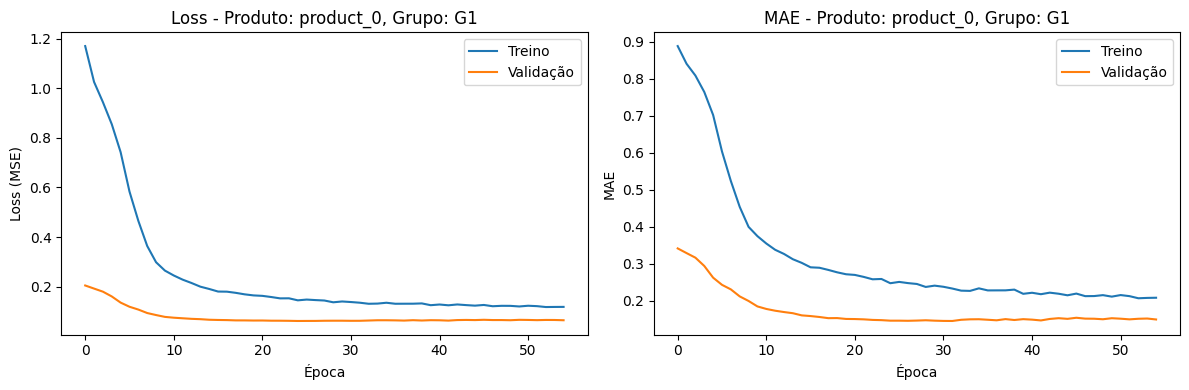

Produto: product_0, Grupo: G2
   Train: 1464 amostras
   Val:   214 amostras
--------------------------------------------------

Epoch 1: val_loss improved from None to 0.54911, saving model to models_mlp\mlp_product_0_G2.keras

Epoch 2: val_loss improved from 0.54911 to 0.50976, saving model to models_mlp\mlp_product_0_G2.keras

Epoch 3: val_loss improved from 0.50976 to 0.46183, saving model to models_mlp\mlp_product_0_G2.keras

Epoch 4: val_loss improved from 0.46183 to 0.38225, saving model to models_mlp\mlp_product_0_G2.keras

Epoch 5: val_loss improved from 0.38225 to 0.29190, saving model to models_mlp\mlp_product_0_G2.keras

Epoch 6: val_loss improved from 0.29190 to 0.22002, saving model to models_mlp\mlp_product_0_G2.keras

Epoch 7: val_loss improved from 0.22002 to 0.17059, saving model to models_mlp\mlp_product_0_G2.keras

Epoch 8: val_loss improved from 0.17059 to 0.14673, saving model to models_mlp\mlp_product_0_G2.keras

Epoch 9: val_loss improved from 0.14673 to 0.13187

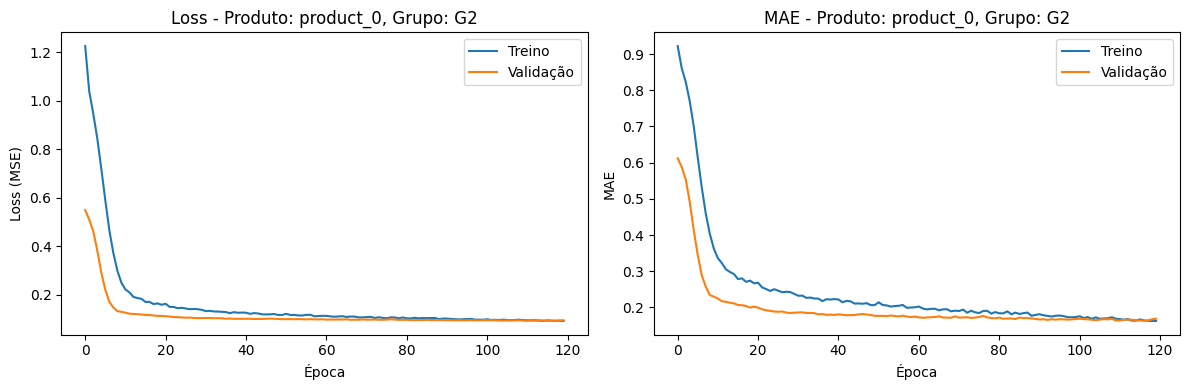

Produto: product_0, Grupo: G3
   Train: 1464 amostras
   Val:   214 amostras
--------------------------------------------------

Epoch 1: val_loss improved from None to 0.29346, saving model to models_mlp\mlp_product_0_G3.keras

Epoch 2: val_loss improved from 0.29346 to 0.28106, saving model to models_mlp\mlp_product_0_G3.keras

Epoch 3: val_loss did not improve from 0.28106

Epoch 4: val_loss improved from 0.28106 to 0.27648, saving model to models_mlp\mlp_product_0_G3.keras

Epoch 5: val_loss improved from 0.27648 to 0.26166, saving model to models_mlp\mlp_product_0_G3.keras

Epoch 6: val_loss improved from 0.26166 to 0.23163, saving model to models_mlp\mlp_product_0_G3.keras

Epoch 7: val_loss improved from 0.23163 to 0.21633, saving model to models_mlp\mlp_product_0_G3.keras

Epoch 8: val_loss improved from 0.21633 to 0.21094, saving model to models_mlp\mlp_product_0_G3.keras

Epoch 9: val_loss improved from 0.21094 to 0.20058, saving model to models_mlp\mlp_product_0_G3.keras

Ep

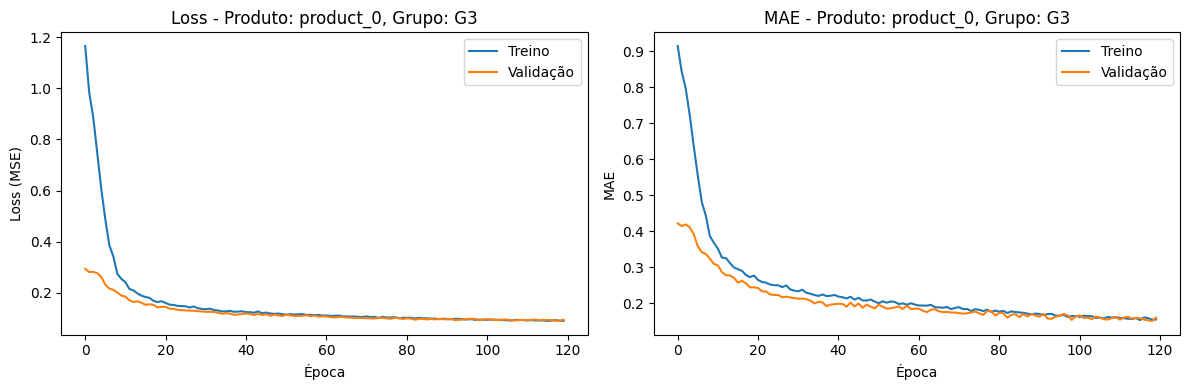

Produto: product_0, Grupo: G4
   Train: 1464 amostras
   Val:   214 amostras
--------------------------------------------------

Epoch 1: val_loss improved from None to 0.61797, saving model to models_mlp\mlp_product_0_G4.keras

Epoch 2: val_loss improved from 0.61797 to 0.58849, saving model to models_mlp\mlp_product_0_G4.keras

Epoch 3: val_loss improved from 0.58849 to 0.56590, saving model to models_mlp\mlp_product_0_G4.keras

Epoch 4: val_loss improved from 0.56590 to 0.54741, saving model to models_mlp\mlp_product_0_G4.keras

Epoch 5: val_loss improved from 0.54741 to 0.51571, saving model to models_mlp\mlp_product_0_G4.keras

Epoch 6: val_loss improved from 0.51571 to 0.46328, saving model to models_mlp\mlp_product_0_G4.keras

Epoch 7: val_loss improved from 0.46328 to 0.40372, saving model to models_mlp\mlp_product_0_G4.keras

Epoch 8: val_loss improved from 0.40372 to 0.34763, saving model to models_mlp\mlp_product_0_G4.keras

Epoch 9: val_loss improved from 0.34763 to 0.30255

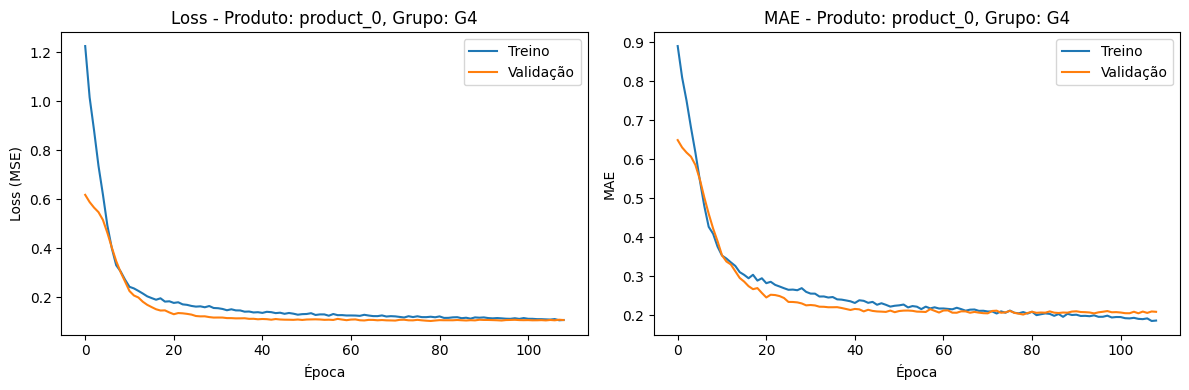

Produto: product_1, Grupo: G1
   Train: 1464 amostras
   Val:   214 amostras
--------------------------------------------------

Epoch 1: val_loss improved from None to 0.87370, saving model to models_mlp\mlp_product_1_G1.keras

Epoch 2: val_loss improved from 0.87370 to 0.74921, saving model to models_mlp\mlp_product_1_G1.keras

Epoch 3: val_loss improved from 0.74921 to 0.68188, saving model to models_mlp\mlp_product_1_G1.keras

Epoch 4: val_loss improved from 0.68188 to 0.60115, saving model to models_mlp\mlp_product_1_G1.keras

Epoch 5: val_loss improved from 0.60115 to 0.48818, saving model to models_mlp\mlp_product_1_G1.keras

Epoch 6: val_loss improved from 0.48818 to 0.35021, saving model to models_mlp\mlp_product_1_G1.keras

Epoch 7: val_loss improved from 0.35021 to 0.27276, saving model to models_mlp\mlp_product_1_G1.keras

Epoch 8: val_loss improved from 0.27276 to 0.21970, saving model to models_mlp\mlp_product_1_G1.keras

Epoch 9: val_loss improved from 0.21970 to 0.18068

In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input

df_feat = df_feat.dropna().reset_index(drop=True)

# FEATURE E TARGETS
x_cols = [
    'points',
    'points_ma_7', 'points_ma_14', 'points_ma_21', 'points_ma_28',
    'points_ma_34', 'points_ma_60', 'points_ma_90', 'points_ma_180',
    'spend_ma_7', 'spend_ma_14', 'spend_ma_21', 'spend_ma_28',
    'spend_ma_34', 'spend_ma_60', 'spend_ma_90', 'spend_ma_180',
    'spend_lag1'
]

y_cols = [
    'total_spend', 'target_spend_ma180_tplus0',   'target_spend_ma180_tplus1',
    'target_spend_ma180_tplus2',  'target_spend_ma180_tplus3',   'target_spend_ma180_tplus4',
    'target_spend_ma180_tplus5',  'target_spend_ma180_tplus6',   'target_spend_ma180_tplus7',
    'target_spend_ma180_tplus8',  'target_spend_ma180_tplus9',   'target_spend_ma180_tplus10',
    'target_spend_ma180_tplus11', 'target_spend_ma180_tplus12',  'target_spend_ma180_tplus13'
]


# Separação temporal
train_df = df_feat[df_feat['date'] < '2024-06-01']
val_df   = df_feat[(df_feat['date'] >= '2024-06-01') & (df_feat['date'] < '2025-01-01')]
test_df  = df_feat[df_feat['date'] >= '2025-01-01']

# Pasta para salvar modelos
model_dir = "models_mlp"
os.makedirs(model_dir, exist_ok=True)

def build_mlp(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(16, activation='relu'),
        Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def plot_training_history(history, product, group_id):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax[0].plot(history.history['loss'], label='Treino')
    ax[0].plot(history.history['val_loss'], label='Validação')
    ax[0].set_title(f'Loss - Produto: {product}, Grupo: {group_id}')
    ax[0].set_xlabel('Época')
    ax[0].set_ylabel('Loss (MSE)')
    ax[0].legend()

    # MAE
    ax[1].plot(history.history['mae'], label='Treino')
    ax[1].plot(history.history['val_mae'], label='Validação')
    ax[1].set_title(f'MAE - Produto: {product}, Grupo: {group_id}')
    ax[1].set_xlabel('Época')
    ax[1].set_ylabel('MAE')
    ax[1].legend()

    plt.tight_layout()
    plt_path = os.path.join(model_dir, f"history_{product}_{group_id}.png")
    plt.savefig(plt_path)
    if product == 'product_0':
        plt.show()
    plt.close()

def train_mlp_model(X_train, y_train, X_val, y_val, product, group_id):
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    # Normalização
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_val_scaled = scaler_x.transform(X_val)
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)

    model = build_mlp(X_train.shape[1], y_train.shape[1])

    checkpoint_path = os.path.join(model_dir, f"mlp_{product}_{group_id}.keras")
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=2)
    earlystop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=2)

    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=120,
        batch_size=64,
        callbacks=[earlystop, checkpoint],
        verbose=0,
        shuffle = True
    )

    plot_training_history(history, product, group_id)

    return model, scaler_x, scaler_y, checkpoint_path

# Dicionário para guardar modelos
mlp_models = {}

# Loop por produto e grupo
for product in df_feat['product'].unique():
    for group_id in df_feat['group_id'].unique():
        train_grp = train_df[(train_df['product'] == product) & (train_df['group_id'] == group_id)]
        val_grp   = val_df[(val_df['product'] == product) & (val_df['group_id'] == group_id)]

        print(f"Produto: {product}, Grupo: {group_id}")
        print(f"   Train: {len(train_grp)} amostras")
        print(f"   Val:   {len(val_grp)} amostras")
        print("-" * 50)

        if len(train_grp) < 30 or len(val_grp) < 10:
            print("   Dados insuficientes. Pulando...")
            continue

        X_train = train_grp[x_cols].values
        y_train = train_grp[y_cols].values
        X_val = val_grp[x_cols].values
        y_val = val_grp[y_cols].values

        model, scaler_x, scaler_y, model_path = train_mlp_model(X_train, y_train, X_val, y_val, product, group_id)

        mlp_models[(product, group_id)] = {
            'model': model,
            'scaler_x': scaler_x,
            'scaler_y': scaler_y,
            'model_path': model_path
        }


In [13]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

def evaluate_model(product, group_id, models, test_df, x_cols, y_cols):
    """
    Avalia o modelo para o grupo/produto fornecido nos dados de teste.
    Retorna um dataframe com predições, reais e métricas.
    """
    # Seleção do subconjunto de teste
    test_grp = test_df[(test_df['product'] == product) & (test_df['group_id'] == group_id)].copy()

    if len(test_grp) == 0:
        print(f"[AVISO] Nenhum dado de teste para produto={product}, grupo={group_id}")
        return None

    if (product, group_id) not in models:
        print(f"[AVISO] Modelo não treinado para produto={product}, grupo={group_id}")
        return None

    # Previsão
    X_test = test_grp[x_cols].values
    y_true = test_grp[y_cols].values

    model = models[(product, group_id)]
    y_pred = model.predict(X_test)

    # DataFrame com resultados
    df_result = test_grp[['date', 'product', 'group_id']].copy()
    for i, col in enumerate(y_cols):
        df_result[f'{col}_true'] = y_true[:, i]
        df_result[f'{col}_pred'] = y_pred[:, i]

    # Cálculo das métricas
    maes = [mean_absolute_error(y_true[:, i], y_pred[:, i]) for i in range(len(y_cols))]
    mae_mean = np.mean(maes)

    print(f"Avaliação - Produto: {product}, Grupo: {group_id}")
    for i, mae in enumerate(maes):
        print(f"  MAE (cum_qty_{i}): {mae:.2f}")
    print(f"MAE médio (14 horizontes): {mae_mean:.2f}")
    print("-" * 40)

    return df_result


In [14]:
from sklearn.metrics import r2_score

def predict_mlp(product, group_id, X_test):
    info = mlp_models.get((product, group_id))
    if info is None:
        print(f"Modelo para produto {product} grupo {group_id} não encontrado.")
        return None

    model = info['model']
    scaler_x = info['scaler_x']
    scaler_y = info['scaler_y']

    X_test_scaled = scaler_x.transform(X_test)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    return y_pred

# Prepare o DataFrame de teste para facilitar extração
test_df = df_feat[df_feat['date'] >= '2025-01-01']

results = []

for (product, group_id), info in mlp_models.items():
    test_grp = test_df[(test_df['product'] == product) & (test_df['group_id'] == group_id)]
    if len(test_grp) == 0:
        print(f"Sem dados de teste para Produto: {product}, Grupo: {group_id}. Pulando...")
        continue
    
    X_test = test_grp[x_cols].values
    y_test = test_grp[y_cols].values
    
    # Previsão e inversão da normalização
    y_pred = predict_mlp(product, group_id, X_test)
    if y_pred is None:
        continue
    
    # Calcular R² para cada horizonte (cada coluna)
    r2_scores = []
    for i, target_col in enumerate(y_cols):
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        r2_scores.append(r2)
    
    # Média R² para relatório
    r2_mean = np.mean(r2_scores)
    
    # Guardar resultado
    results.append({
        'product': product,
        'group_id': group_id,
        'r2_mean': r2_mean,
        **{f'r2_{h}': r2_scores[h] for h in range(len(y_cols))}
    })

# Mostrar resultados
results_df = pd.DataFrame(results).sort_values(['product','group_id'])
results_df


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,product,group_id,r2_mean,r2_0,r2_1,r2_2,r2_3,r2_4,r2_5,r2_6,r2_7,r2_8,r2_9,r2_10,r2_11,r2_12,r2_13,r2_14
0,product_0,G1,0.717748,0.003950,0.793000,0.710233,0.754598,0.723306,0.689426,0.717621,0.805185,0.814926,0.803818,0.805650,0.767754,0.754454,0.786484,0.835820
1,product_0,G2,0.799212,0.018970,0.907166,0.870781,0.878945,0.866179,0.861875,0.871416,0.885336,0.858232,0.847501,0.822208,0.825907,0.826085,0.826190,0.821383
2,product_0,G3,0.788690,0.042993,0.813999,0.805419,0.823296,0.804417,0.847561,0.832811,0.868825,0.850793,0.865113,0.856863,0.857120,0.856578,0.851797,0.852761
3,product_0,G4,0.544688,-0.002153,0.766396,0.713990,0.724211,0.698402,0.669994,0.634177,0.627432,0.572345,0.513854,0.505145,0.451952,0.439640,0.435337,0.419595
4,product_1,G1,0.253462,0.061796,0.585733,0.519197,0.542290,0.520920,0.378016,0.392617,0.324551,0.226540,0.282988,0.229575,0.061825,-0.054959,-0.110919,-0.158235
5,product_1,G2,0.191793,0.003154,0.343080,0.302468,0.321664,0.219129,0.348879,0.185310,0.251530,0.101684,0.165296,0.148274,0.235198,0.039190,0.108861,0.103169
6,product_1,G3,-0.240834,-0.025052,0.044990,-0.469931,0.111737,-0.021548,-0.194653,-0.608490,-0.425693,-0.577839,-0.337035,-0.202869,-0.553334,-0.177637,-0.052680,-0.122478
7,product_1,G4,0.453507,-0.005969,0.835123,0.785201,0.695984,0.573323,0.560739,0.519488,0.531867,0.459297,0.387002,0.399146,0.345636,0.332421,0.214015,0.169332
8,product_2,G1,0.763506,0.749378,0.856298,0.762048,0.776547,0.762921,0.778173,0.809938,0.847363,0.735897,0.678245,0.703944,0.699970,0.705820,0.767881,0.818161
9,product_2,G2,0.690504,0.589427,0.822675,0.750164,0.743105,0.739118,0.723072,0.758170,0.774414,0.693402,0.642183,0.611299,0.614881,0.591932,0.615159,0.688557


# Usando de forma sequencial e fazendo múltiplas alocações

In [17]:
def get_history_for_pair(df_gp, product, group_id, lookback=180):
    """
    Retorna histórico dos últimos `lookback` dias com colunas
    necessárias para x_cols, principalmente 'points', 'spend_lag1' e medias móveis.
    """
    grp = df_gp[(df_gp['product']==product) & (df_gp['group_id']==group_id)]
    grp = grp.sort_values('date').set_index('date')
    last = grp.index.max()
    # As colunas devem conter as features usadas no modelo
    cols_needed = ['points', 'total_spend']  # points e total_spend básicos para gerar lag e médias
    # Pode ter outras colunas extras se quiser, mas vamos manter só essenciais
    return grp.loc[last - pd.Timedelta(days=lookback-1): last, cols_needed].copy(), last


WINDOWS = [180, 90, 60, 34, 28, 21, 14, 7]

def enrich_history_with_features(h):
    """
    Cria colunas:
    - spend_lag1 (lag1 de total_spend)
    - points_ma_*, spend_ma_* (médias móveis)
    """
    h = h.copy()
    h['spend_lag1'] = h['total_spend'].shift(1).fillna(0)

    for w in WINDOWS:
        h[f'points_ma_{w}'] = h['points'].rolling(w, min_periods=1).mean()
        h[f'spend_ma_{w}'] = h['spend_lag1'].rolling(w, min_periods=1).mean()
    return h


def compute_response_curve(history, model_info, x_cols, y_cols, B=5000, step=1):
    model, scaler_x, scaler_y = model_info['model'], model_info['scaler_x'], model_info['scaler_y']
    pts = np.arange(0, B+1, step)
    sp = np.zeros_like(pts, dtype=float)

    for i, x in enumerate(pts):
        h = history.copy()
        today = h.index.max() + pd.Timedelta(days=1)
        # Em 'points' insere o orçamento x e em 'total_spend' insere 0 para o dia novo
        h.loc[today] = {'points': x, 'total_spend': 0}
        h = enrich_history_with_features(h)
        feats = h.loc[today, x_cols].values.reshape(1, -1)
        yhat_s = model.predict(scaler_x.transform(feats), verbose=0)
        yhat = scaler_y.inverse_transform(yhat_s)[0]
        sp[i] = yhat.mean()
    return pts, sp


def predict_todays_spend(df_gp, alloc, x_cols, y_cols, mlp_models, lookback=180):
    next_s = {}
    for (p, g), x in alloc.items():
        history, last = get_history_for_pair(df_gp, p, g, lookback)
        today = last + pd.Timedelta(days=1)
        # No histórico para o dia novo, aloca 'points' e zera 'total_spend' para prever
        history.loc[today] = {'points': x, 'total_spend': 0}
        h = enrich_history_with_features(history)
        feats = h.loc[today, x_cols].values.reshape(1, -1)
        info = mlp_models[(p, g)]
        yhat_s = info['model'].predict(info['scaler_x'].transform(feats), verbose=0)
        yhat = info['scaler_y'].inverse_transform(yhat_s)[0]
        next_s[(p, g)] = yhat[0]
    return next_s


def recursive_allocation_forecast(
    df_gp, mlp_models, x_cols, y_cols,
    steps: int, B: int=5000, lookback: int=180,
    step: int = 100
):
    history = df_gp.copy()
    records = []

    for _ in range(steps):
        response_curves = {}
        for key, info in mlp_models.items():
            h, _ = get_history_for_pair(history, *key, lookback)
            pts, sp = compute_response_curve(h, info, x_cols, y_cols, B=B, step=step)
            response_curves[key] = (pts, sp)

        alloc = allocate_budget_dp(response_curves, B=B, step=step)

        next_spend = predict_todays_spend(history, alloc, x_cols, y_cols, mlp_models, lookback)
        new_date = history['date'].max() + pd.Timedelta(days=1)
        new_rows = []

        for (product, group_id), x in alloc.items():
            s_hat = next_spend[(product, group_id)]
            new_rows.append({
                'product': product,
                'group_id': group_id,
                'date': new_date,
                'points': x,           # orçamento aplicado (feature)
                'total_spend': s_hat   # gasto previsto (target)
            })
            records.append(new_rows[-1])

        history = pd.concat([history, pd.DataFrame(new_rows)], ignore_index=True)

    return history, pd.DataFrame(records)

def allocate_budget_dp(response_curves, B=5000, step=1):
    """
    Aloca até B unidades de pontos entre os pares (product, group_id)
    para maximizar a soma da receita prevista com base nas curvas de resposta.

    response_curves: dict (chave=(product, group_id), valor=(points_array, spend_array))
    B: orçamento total de pontos
    step: granularidade de alocação (por exemplo, 100 => alocações em 0, 100, 200, ...)
    
    Retorna:
        dicionário { (product, group_id): points_allocated }
    """
    keys = list(response_curves.keys())
    n = len(keys)
    m = B // step  # número de unidades discretas

    # DP[i][b] = melhor valor possível usando os i primeiros pares e b unidades
    DP = np.zeros((n+1, m+1))
    choice = np.zeros((n+1, m+1), dtype=int)

    for i in range(1, n+1):
        pts, sp = response_curves[keys[i-1]]
        sp_interp = np.interp(np.arange(0, B+1, step), pts, sp)

        for b in range(m+1):
            best_val = DP[i-1][b]
            best_k = 0

            for k in range(0, b+1):
                val = DP[i-1][b-k] + sp_interp[k]
                if val > best_val:
                    best_val = val
                    best_k = k
            DP[i][b] = best_val
            choice[i][b] = best_k

    # Reconstruir solução
    alloc = {}
    b = m
    for i in range(n, 0, -1):
        k = choice[i][b]
        alloc[keys[i-1]] = k * step
        b -= k

    return alloc



In [18]:
extended_df, alloc_schedule = recursive_allocation_forecast(
    df_gp, mlp_models, x_cols, y_cols,
    steps=2, B=5000, lookback=180, step=1000,
)

In [19]:
import random

def simple_distribute_points(clients, P):
    """
    Distribui P pontos entre os clientes de forma round-robin:
      - Enquanto P >= 10:
          * Escolhe um cliente em sequência (round-robin)
          * Filtra chunks = [500,300,200,100,50,10] que sejam <= P
          * Sorteia aleatoriamente um desses chunks
          * Atribui ao cliente e subtrai de P
      - Se sobrar 1 <= P < 10, atribui todo esse remanescente ao primeiro cliente
    Retorna dict client->pontos.
    """
    alloc = {c: 0 for c in clients}
    chunks = [500, 300, 200, 100, 50, 10]
    idx = 0

    # Enquanto der para usar ao menos o menor chunk (10)
    while P >= 10:
        client = clients[idx % len(clients)]
        # Só consideramos pedaços que cabem no P restante
        possible = [c for c in chunks if c <= P]
        # Sorteamos um tamanho dentre os possíveis
        chosen = random.choice(possible)
        alloc[client] += chosen
        P -= chosen
        idx += 1

    # Remanescente < 10: joga tudo no primeiro cliente da lista
    if P > 0:
        alloc[clients[0]] += P

    return alloc

In [20]:
def expand_group_alloc_to_clients(alloc_schedule: pd.DataFrame, group_map: pd.DataFrame):
    """
    Recebe:
      - alloc_schedule: DataFrame com colunas ['date','product','group_id','points']
      - group_map:       DataFrame com colunas ['product','client','group_id']
    Retorna:
      DataFrame com ['date','product','client','points'] para cada client,
      usando simple_distribute_points para repartir os pontos do grupo.
      Linhas com points==0 são descartadas.
    """
    records = []
    # itera cada linha de alocação de grupo
    for _, row in alloc_schedule.iterrows():
        date      = row['date']
        product   = row['product']
        group_id  = row['group_id']
        P         = int(row['points'])
        # lista de clients do grupo
        clients = (
            group_map
            .loc[
                (group_map['product']==product) &
                (group_map['group_id']==group_id),
                'client'
            ]
            .tolist()
        )
        if not clients or P<=0:
            continue
        # distribui pelos clients
        client_allocs = simple_distribute_points(clients, P)
        # transforma em registros
        for client, pts in client_allocs.items():
            if pts > 0:
                records.append({
                    'date':    date,
                    'product': product,
                    'client':  client,
                    'points':  pts
                })

    return pd.DataFrame(records)

client_alloc_df = expand_group_alloc_to_clients(alloc_schedule, group_map)

In [21]:
base_path = Path(__file__).parent if '__file__' in globals() else Path().resolve()

# salva no arquivo solution.csv dentro de base_path
output_path = base_path / "solution.csv"
client_alloc_df.to_csv(output_path, index=False)

print(f"Arquivo salvo em {output_path}")
print(client_alloc_df)

Arquivo salvo em C:\Users\engen\OneDrive\Área de Trabalho\desafio_mt2\solution.csv
         date    product     client  points
0  2025-07-13  product_2   client_6     100
1  2025-07-13  product_2  client_35     510
2  2025-07-13  product_2   client_4      50
3  2025-07-13  product_2  client_76     500
4  2025-07-13  product_2  client_51      50
5  2025-07-13  product_2  client_85     300
6  2025-07-13  product_2  client_10     300
7  2025-07-13  product_2  client_47     200
8  2025-07-13  product_2  client_86      50
9  2025-07-13  product_2   client_0      10
10 2025-07-13  product_2   client_8     500
11 2025-07-13  product_2   client_7     100
12 2025-07-13  product_2  client_22     100
13 2025-07-13  product_2  client_99     500
14 2025-07-13  product_2  client_79      10
15 2025-07-13  product_2  client_26      10
16 2025-07-13  product_2  client_31     100
17 2025-07-13  product_2  client_97     200
18 2025-07-13  product_2  client_71     300
19 2025-07-13  product_2  client_80  